# DIALOGUE

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pickle as pkl

import anndata as ad
import numpy as np
import pandas as pd
import pertpy as pt
import scanpy as sc

In [3]:
adata = pt.dt.zhang_2021()

In [4]:
adata

AnnData object with n_obs × n_vars = 489490 × 27085
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster'

## TG preprocessing

In [5]:
# The Mix cell type is mostly T-cells but it's not perfectly clear what they are
# Could also likely be low quality cells
adata = adata[~adata.obs.Cluster.isin(["Mix"])]

In [6]:
adata = adata[adata.obs["Origin"] == "t", :].copy()

In [7]:
adata = adata[adata.obs["Sample"].str.contains("Pre"), :].copy()
adata

AnnData object with n_obs × n_vars = 85073 × 27085
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster'

In [8]:
sc.pp.filter_genes(adata, min_cells=10)

In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [10]:
sc.pp.log1p(adata)

In [11]:
sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor="seurat_v3")

In [12]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

In [13]:
sc.pp.scale(adata, max_value=10)

In [14]:
sc.tl.pca(adata, svd_solver="arpack")

## Now TG pre DLG

In [15]:
isecs = pd.crosstab(adata.obs["Cluster"], adata.obs["Sample"])

In [16]:
isecs[(isecs > 3).sum(axis=1) == np.shape(isecs)[1]]

Sample,Pre_P002_t,Pre_P004_t,Pre_P005_t,Pre_P007_t,Pre_P010_t,Pre_P012_t,Pre_P013_t,Pre_P016_t,Pre_P017_t,Pre_P018_t,Pre_P019_t,Pre_P020_t,Pre_P022_t,Pre_P023_t,Pre_P025_t
Cluster,,,,,,,,,,,,,,,
t_pB-IGHG1,679,8,12,12,4,301,4,136,14,238,1753,911,1083,206,283


In [17]:
isecs[(isecs > 3).sum(axis=1) == np.shape(isecs)[1] - 1]

Sample,Pre_P002_t,Pre_P004_t,Pre_P005_t,Pre_P007_t,Pre_P010_t,Pre_P012_t,Pre_P013_t,Pre_P016_t,Pre_P017_t,Pre_P018_t,Pre_P019_t,Pre_P020_t,Pre_P022_t,Pre_P023_t,Pre_P025_t
Cluster,,,,,,,,,,,,,,,
t_CD4_Tcm-LMNA,4,392,569,249,0,288,6,311,20,134,555,77,593,444,87
t_CD4_Treg-FOXP3,13,338,110,62,0,464,24,419,17,518,769,743,398,122,130
t_CD8_Tem-GZMK,8,957,368,72,0,417,17,176,21,154,2354,202,709,891,292
t_Tn-LEF1,11,98,110,3494,0,1269,22,50,609,167,4010,175,1501,388,271


In [18]:
isecs[(isecs > 3).sum(axis=1) == np.shape(isecs)[1] - 2]

Sample,Pre_P002_t,Pre_P004_t,Pre_P005_t,Pre_P007_t,Pre_P010_t,Pre_P012_t,Pre_P013_t,Pre_P016_t,Pre_P017_t,Pre_P018_t,Pre_P019_t,Pre_P020_t,Pre_P022_t,Pre_P023_t,Pre_P025_t
Cluster,,,,,,,,,,,,,,,
t_Bmem-CD27,377,11,12,105,0,1950,0,11,166,22,4210,132,309,121,400
t_CD8_MAIT-KLRB1,0,51,1244,45,0,40,7,84,24,19,67,14,38,20,11
t_CD8_Trm-ZNF683,3,76,180,71,0,143,4,407,4,226,422,121,449,219,150
t_mono-FCN1,4,60,11,12,0,14,23,44,1,31,43,15,51,33,16


In [19]:
celltypes = isecs[(isecs > 3).sum(axis=1) >= np.shape(isecs)[1] - 2].index.values.tolist()

In [20]:
adata = adata[adata.obs["Cluster"].isin(celltypes), :].copy()
adata

AnnData object with n_obs × n_vars = 44636 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [21]:
isecs = pd.crosstab(adata.obs["Cluster"], adata.obs["Sample"])

In [22]:
keep_pts = isecs.loc[:, (isecs > 3).sum(axis=0) == isecs.shape[0]].columns.values.tolist()

In [23]:
adata = adata[adata.obs["Sample"].isin(keep_pts), :].copy()

In [24]:
pd.crosstab(adata.obs["Cluster"], adata.obs["Sample"]).min(axis=1)

Cluster
t_Bmem-CD27         11
t_CD4_Tcm-LMNA      77
t_CD4_Treg-FOXP3    62
t_CD8_MAIT-KLRB1    11
t_CD8_Tem-GZMK      72
t_CD8_Trm-ZNF683    71
t_Tn-LEF1           50
t_mono-FCN1         11
t_pB-IGHG1           8
dtype: int64

In [25]:
pd.crosstab(adata.obs["Cluster"], adata.obs["Sample"]).min(axis=0)

Sample
Pre_P004_t     8
Pre_P005_t    11
Pre_P007_t    12
Pre_P012_t    14
Pre_P016_t    11
Pre_P018_t    19
Pre_P019_t    43
Pre_P020_t    14
Pre_P022_t    38
Pre_P023_t    20
Pre_P025_t    11
dtype: int64

In [26]:
adata

AnnData object with n_obs × n_vars = 42550 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [27]:
# sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [28]:
adata_plot = sc.pp.subsample(adata, n_obs=10000, random_state=0, copy=True)

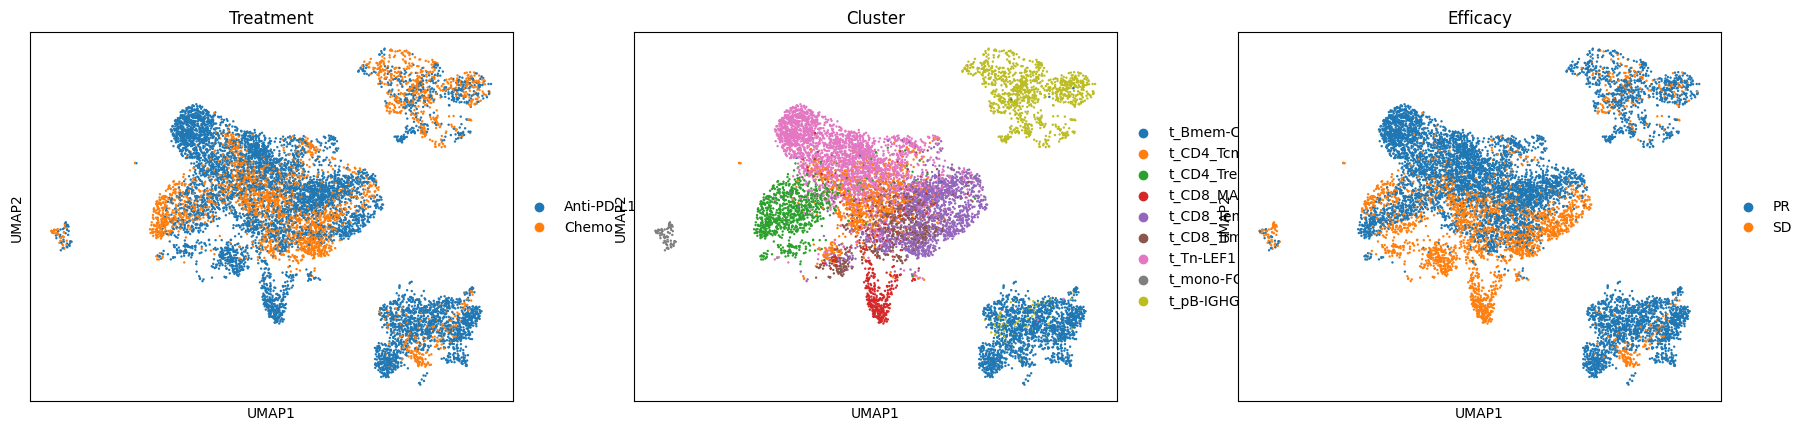

In [29]:
sc.pl.umap(
    adata_plot,
    color=["Treatment", "Cluster", "Efficacy"],
)

## Run DIALOGUE

### LP solver

In [30]:
adata_lp = adata.copy()

In [31]:
# necessary to ensure that the petsy doesn't complain and scikit-learn neither
adata_lp.obs.rename(columns={"Number of counts": "n_counts"}, inplace=True)
adata_lp.obs["n_counts"] = adata_lp.obs["n_counts"].str.replace(",", "").str.strip().astype(float)

In [32]:
dl_lp = pt.tl.Dialogue(sample_id="Sample", celltype_key="Cluster", n_counts_key="n_counts", n_mpcs=10)

adata_lp, mcps_lp, ws_lp, ct_subs_lp = dl_lp.calculate_multifactor_PMD(adata_lp, normalize=True, solver="lp")

In [33]:
lp_test_results = dl_lp.test_association(adata_lp, condition_label="Efficacy")

In [34]:
pvals_lp = lp_test_results["pvals"]

In [35]:
pvals_lp.min()

mcp_0    0.167367
mcp_1    0.016421
mcp_2    0.467716
mcp_3    0.306697
mcp_4    0.043164
mcp_5    0.086826
mcp_6    0.127406
mcp_7    0.216590
mcp_8    0.382802
mcp_9    0.039881
dtype: float64

In [36]:
tstats_lp = lp_test_results["tstats"]

In [37]:
pvals_adj = lp_test_results["pvals_adj"]

In [38]:
dlg_dict = {
    "mcps": mcps_lp,
    "ws": ws_lp,
    "ct_subs": ct_subs_lp,
    "pvals": pvals_lp,
    "pvals_adj": pvals_adj,
    "tstats": tstats_lp,
}
outfile = "dialogue_lp.pkl"
with open(outfile, "wb") as pickle_file:
    pkl.dump(dlg_dict, pickle_file)
pickle_file.close()

In [39]:
adata_lp.write_h5ad("dialogue_lp.h5ad")

### BS solver

In [40]:
adata_bs = adata.copy()

In [41]:
# necessary to ensure that the petsy doesn't complain and scikit-learn neither
adata_bs.obs.rename(columns={"Number of counts": "n_counts"}, inplace=True)
adata_bs.obs["n_counts"] = adata_bs.obs["n_counts"].str.replace(",", "").str.strip().astype(float)

In [42]:
dl_bs = pt.tl.Dialogue(sample_id="Sample", celltype_key="Cluster", n_counts_key="n_counts", n_mpcs=10)

adata_bs, mcps_bs, ws_bs, ct_subs_bs = dl_bs.calculate_multifactor_PMD(adata_bs, normalize=True, solver="bs")

bs_test_results = dl_bs.test_association(adata_bs, condition_label="Efficacy")

In [43]:
pvals_bs = bs_test_results["pvals"]

In [44]:
pvals_bs.min()

mcp_0    0.125285
mcp_1    0.067438
mcp_2    0.173036
mcp_3    0.166016
mcp_4    0.025018
mcp_5    0.391545
mcp_6    0.299774
mcp_7    0.310934
mcp_8    0.380011
mcp_9    0.085995
dtype: float64

In [45]:
pvals_adj = bs_test_results["pvals_adj"]

In [46]:
tstats_bs = bs_test_results["tstats"]

In [47]:
dlg_dict = {
    "mcps": mcps_bs,
    "ws": ws_bs,
    "ct_subs": ct_subs_bs,
    "pvals": pvals_bs,
    "pvals_adj": pvals_adj,
    "tstats": tstats_bs,
}
outfile = "dialogue_bs.pkl"
with open(outfile, "wb") as pickle_file:
    pkl.dump(dlg_dict, pickle_file)
pickle_file.close()

In [48]:
adata_bs.write_h5ad("dialogue_bs.h5ad")

## Visualizations

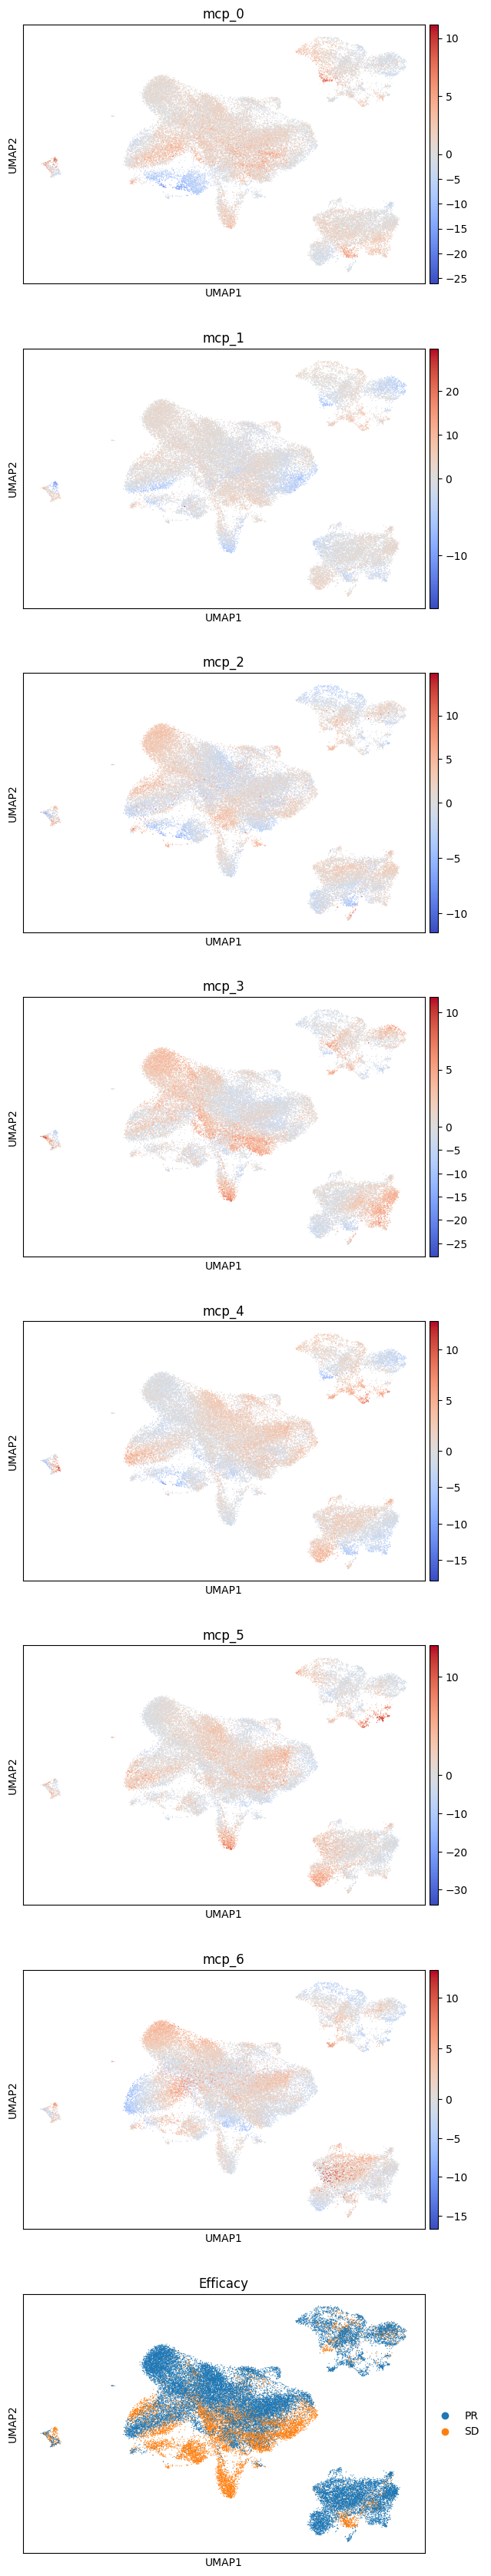

In [49]:
sc.pl.umap(
    adata_lp,
    color=["mcp_0", "mcp_1", "mcp_2", "mcp_3", "mcp_4", "mcp_5", "mcp_6", "Efficacy"],
    ncols=1,
    cmap="coolwarm",
    vcenter=0,
)

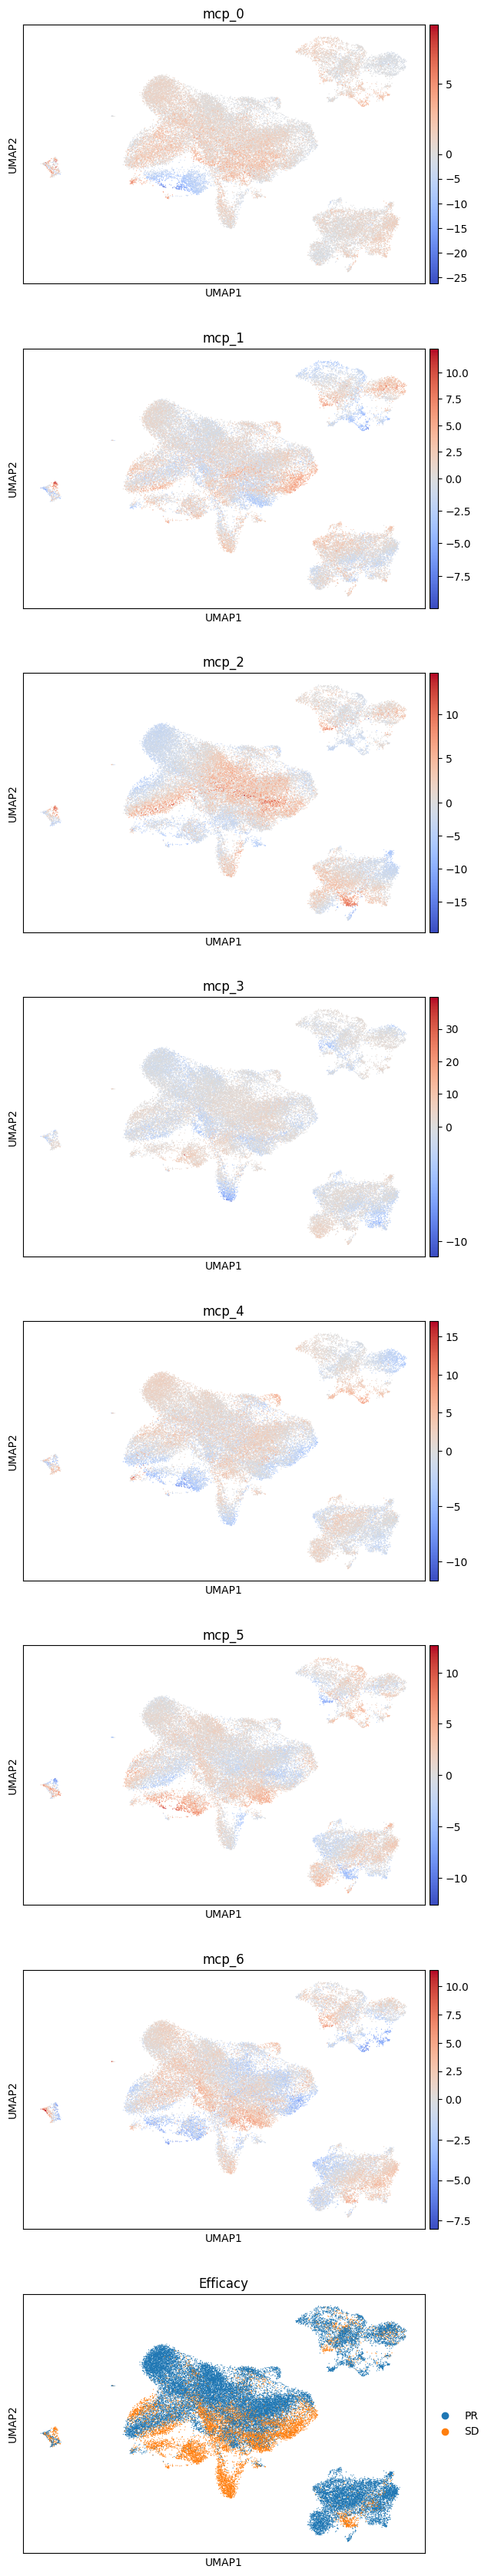

In [50]:
sc.pl.umap(
    adata_bs,
    color=["mcp_0", "mcp_1", "mcp_2", "mcp_3", "mcp_4", "mcp_5", "mcp_6", "Efficacy"],
    ncols=1,
    cmap="coolwarm",
    vcenter=0,
)

## Store extrema genes

In [53]:
dl = pt.tl.Dialogue(sample_id="Sample", celltype_key="Cluster", n_counts_key="n_counts", n_mpcs=10)
extrema_genes = dl.get_extrema_MCP_genes(dlg_dict["ct_subs"])

In [ ]:
mapping = {
    "t_CD4_Tcm-LMNA": "CD4 Tcm cells",
    "t_pB-IGHG1": "Plasma B cells",
    "t_Bmem-CD27": "Memory B cells",
    "t_CD8_MAIT-KLRB1": "CD8 MAIT cells",
    "t_Tn-LEF1": "Naive T cells",
    "t_CD4_Treg-FOXP3": "CD4 regulatory T cells",
    "t_CD8_Tem-GZMK": "CD8 effector memory T cells",
    "t_mono-FCN1": "Intermediate monocytes",
}


renamed_extrema_genes_mcp_2 = {mapping[k]: v for k, v in extrema_genes["mcp_2"].items() if k in mapping}

In [69]:
renamed_extrema_genes_mcp_2["CD4 Tcm cells"].to_csv("LP_cd4_tcm_cells.csv")
renamed_extrema_genes_mcp_2["Plasma B cells"].to_csv("LP_plasma_b_cells.csv")
renamed_extrema_genes_mcp_2["Memory B cells"].to_csv("LP_memory_b_cells.csv")
renamed_extrema_genes_mcp_2["CD8 MAIT cells"].to_csv("LP_cd8_mait_cells.csv")
renamed_extrema_genes_mcp_2["Naive T cells"].to_csv("LP_naive_t_cells.csv")
renamed_extrema_genes_mcp_2["CD4 regulatory T cells"].to_csv("LP_regulatory_t_cells.csv")
renamed_extrema_genes_mcp_2["CD8 effector memory T cells"].to_csv("LP_cd8_effector_memory_t_cells.csv")
renamed_extrema_genes_mcp_2["Intermediate monocytes"].to_csv("LP_intermediate_monoctyes.csv")